
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

In [ ]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/content/project/input"


In [ ]:
os.makedirs('./project/input', exist_ok=True)
os.makedirs('./project/output', exist_ok=True)
%cd project

/content/project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://drive.google.com/file/d/1SrazHXmnJwL4_qBV1EDiVN60mWUMEATn/view?usp=sharing

# !gdown 1oQdnhO7uHgiZKAUY8UJdpk5ig479CZug
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest_X-ray_1024.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input')


In [ ]:
# https://drive.google.com/file/d/1SrazHXmnJwL4_qBV1EDiVN60mWUMEATn/view?usp=sharing

# !gdown 1oQdnhO7uHgiZKAUY8UJdpk5ig479CZug
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest X-ray(512).zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input')


In [ ]:
%pwd

'/content/project'

In [ ]:
# nofinding 제거 버전
df = pd.read_csv('./input/train.csv')
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,image_id,class_id,x_min,y_min,x_max,y_max
6,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.092308,301.369863,406.892308,401.315068
7,9a5094b2563a1ef3ff50dc5c7ff71345,11,440.369231,378.958904,461.538462,436.602740
8,9a5094b2563a1ef3ff50dc5c7ff71345,12,440.369231,378.958904,461.538462,436.602740
9,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.338462,301.369863,407.876923,394.301370
10,9a5094b2563a1ef3ff50dc5c7ff71345,4,169.600000,287.780822,410.092308,386.410959
...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,10,67.333333,256.355556,85.111111,268.088889
67775,52951d7de2485aba8ed62629eee4d254,4,163.111111,279.288889,358.666667,336.355556
67848,1224f07d895107573588225f692e94f9,1,250.729412,161.922261,320.250980,223.434629
67849,1224f07d895107573588225f692e94f9,1,262.525490,155.590106,319.247059,221.399293


==========

convert_to_coco 에서 train image도 jpg로 저장하도록 했습니다.

In [ ]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    res['images'].append({
        'id': pic_name,
        'width': 1024,
        'height':1024,
        'file_name': pic_name+".png"
    })
      
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [ ]:
random.seed(10)

# train_files = glob(os.path.join(base_dir, 'train/*.png'))
# train_files = os.listdir('./input/train')
# train_files = list(map(del_extension, train_files))
train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [ ]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [ ]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip show torch

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


런타임 다시 시작하고 진행합니다.

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 32133, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 32133 (delta 3), reused 22 (delta 1), pack-reused 32099
Receiving objects: 100% (32133/32133), 41.05 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (23124/23124), done.


In [ ]:
%cd ./mmdetection

/content/project/mmdetection


In [ ]:
!pip install openmim
!mim install mmdet==2.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 237 kB 8.3 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 1.3 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 728 kB 4.2 MB/s 
Saved /tmp/tmp4tbpv0hv/mmdet-2.22.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.22.0: ['mmcv-full>=1.3.17'].
     |████████████████████████████████| 40.6 MB 1.5 MB/s 
     |████████████████████████████████| 190 kB 83.3 MB/s 
Using cached `mminstall.txt` for mmdet==2.22.0: /roo

=========

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True
2.25.3
11.3
GCC 9.3


tutorial에 있는 mask_rcnn 모델을 그대로 사용해도 되지만 저는 faster_rcnn 모델을 사용했습니다.

In [ ]:
# %cd mmdetection
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
#       -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

# %cd mmdetection
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
      -O checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-10-26 06:41:26--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.32
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

checkpoints/faster_ 100%[===================>] 159.54M  11.1MB/s    in 14s     

2022-10-26 06:41:41 (11.2 MB/s) - ‘checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
# Choose to use a config and initialize the detector
config = "configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"
# Setup a checkpoint file to load
checkpoint = '/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# initialize the detector
#model = init_detector(config, checkpoint, device='cuda:0')

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [ ]:
import mmcv
import matplotlib.pyplot as plt

import copy
import os.path as osp

import mmcv
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile(config)

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

COCO datasets과 같은 standard datasets에서 미리 정의된 모델(config) 에서 학습하는 방법을 보여 줌

 

config 파일의 기본 learning rate는 GPU 8개와 2 img/gpu (batch size = 8 * 2 = 16)

 

Linear scaling 규칙에 따라 GPU당 다른 GPU 또는 이미지를 사용하는 경우 

배치 크기에 비례하여 학습률을 설정.

 

lr=0.01 for   4 GPUs * 2 imgs/gpu
lr=0.08 for 16 GPUs * 4 imgs/gpu




resume-from 과 load-from의 차이

resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속

(일반적으로 학습하다가 중단되었을  때)

 

load-from : weight만 load 하고 training epoch는 0부터 시작

(일반적으로 fine-tuning 할 때)

 

위를 참고하여 아래의 명령어를 실행하여 faster rcnn COCO dataset 학습을 진행하였다.




In [ ]:
from mmdet.apis import set_random_seed

base_path = '/content/project/input' # base_dir과 같습니다.

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/project/vinBigData/faster/2-1'

EPOCHS= 30




train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"
valid_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"

train_img = "train" # 출력은 "train_100000"
valid_img = 'train'
test_img =  "test" # 출력은 "train_100000"



# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = valid_anno
cfg.data.val.img_prefix = valid_img

#test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img



cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis'
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

#load-from : weight만 load 하고 training epoch
# 사전 학습 모델 사용 (fine-tunning)
cfg.load_from = "/content/project/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"

#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = None

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
optimizer = dict(_delete_=True, type='AdamW', lr=0.0001, betas=(0.9, 0.999), weight_decay=0.05, paramwise_cfg=dict(custom_keys={'absolute_pos_embed': dict(decay_mult=0.),'relative_position_bias_table': dict(decay_mult=0.),'norm': dict(decay_mult=0.)}))
#cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

# 에폭 수 조절
# the max_epochs and step in lr_config need specifically tuned for the customized dataset
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [ ]:
t_files = glob(os.path.join('/content/project/input/train/*.png'))
v_files = glob(os.path.join('/content/project/input/test/*.png'))
len(t_files),len(v_files)

(15000, 3000)

In [ ]:
print(datasets)

[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleural thickening] | 3834  | 12 [Pneumothorax] | 186   | 13 [Pulmonary fibrosis] | 3689

In [27]:
# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-26 06:51:32,050 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-26 06:51:32,095 - mmdet - INFO - load checkpoint from local path: /content/project/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-10-26 06:51:32,227 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([56, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in curren

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-26 06:51:56,861 - mmdet - INFO - Epoch [1][10/440]	lr: 3.000e-04, eta: 9:00:56, time: 2.461, data_time: 0.266, memory: 9886, loss_rpn_cls: 0.3678, loss_rpn_bbox: 0.0773, loss_cls: 0.7239, acc: 87.3828, loss_bbox: 0.1120, loss: 1.2810
2022-10-26 06:52:12,690 - mmdet - INFO - Epoch [1][20/440]	lr: 3.000e-04, eta: 7:24:07, time: 1.583, data_time: 0.117, memory: 9886, loss_rpn_cls: 0.2247, loss_rpn_bbox: 0.0650, loss_cls: 0.2970, acc: 95.9937, loss_bbox: 0.1071, loss: 0.6938
2022-10-26 06:52:28,056 - mmdet - INFO - Epoch [1][30/440]	lr: 3.000e-04, eta: 6:48:16, time: 1.537, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.2239, loss_rpn_bbox: 0.0671, loss_cls: 0.2299, acc: 96.7725, loss_bbox: 0.0791, loss: 0.5999
2022-10-26 06:52:43,601 - mmdet - INFO - Epoch [1][40/440]	lr: 3.000e-04, eta: 6:31:12, time: 1.555, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.1664, loss_rpn_bbox: 0.0550, loss_cls: 0.1914, acc: 96.9238, loss_bbox: 0.0785, loss: 0.4912
2022-10-26 06:52:59,243 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 07:05:21,866 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...


2022-10-26 07:05:25,243 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.68s).


2022-10-26 07:05:44,388 - mmdet - INFO - Epoch [2][10/440]	lr: 3.000e-04, eta: 5:59:31, time: 1.906, data_time: 0.259, memory: 9886, loss_rpn_cls: 0.0620, loss_rpn_bbox: 0.0435, loss_cls: 0.3188, acc: 91.6406, loss_bbox: 0.3090, loss: 0.7333
2022-10-26 07:06:01,679 - mmdet - INFO - Epoch [2][20/440]	lr: 3.000e-04, eta: 5:59:24, time: 1.729, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0682, loss_rpn_bbox: 0.0449, loss_cls: 0.3150, acc: 91.4355, loss_bbox: 0.3233, loss: 0.7513
2022-10-26 07:06:18,659 - mmdet - INFO - Epoch [2][30/440]	lr: 3.000e-04, eta: 5:59:09, time: 1.698, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0629, loss_rpn_bbox: 0.0431, loss_cls: 0.3148, acc: 91.6504, loss_bbox: 0.3233, loss: 0.7441
2022-10-26 07:06:35,277 - mmdet - INFO - Epoch [2][40/440]	lr: 3.000e-04, eta: 5:58:44, time: 1.662, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0605, loss_rpn_bbox: 0.0441, loss_cls: 0.2948, acc: 91.4429, loss_bbox: 0.3085, loss: 0.7079
2022-10-26 07:06:51,817 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 07:19:07,871 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.91s).
Accumulating evaluation results...


2022-10-26 07:19:13,408 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.26s).


2022-10-26 07:19:32,458 - mmdet - INFO - Epoch [3][10/440]	lr: 3.000e-04, eta: 5:46:05, time: 1.895, data_time: 0.265, memory: 9886, loss_rpn_cls: 0.0606, loss_rpn_bbox: 0.0436, loss_cls: 0.3080, acc: 91.3428, loss_bbox: 0.3133, loss: 0.7255
2022-10-26 07:19:49,714 - mmdet - INFO - Epoch [3][20/440]	lr: 3.000e-04, eta: 5:45:53, time: 1.726, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0621, loss_rpn_bbox: 0.0460, loss_cls: 0.3258, acc: 90.9155, loss_bbox: 0.3157, loss: 0.7496
2022-10-26 07:20:06,656 - mmdet - INFO - Epoch [3][30/440]	lr: 3.000e-04, eta: 5:45:37, time: 1.694, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0724, loss_rpn_bbox: 0.0492, loss_cls: 0.3203, acc: 91.2231, loss_bbox: 0.3270, loss: 0.7689
2022-10-26 07:20:23,380 - mmdet - INFO - Epoch [3][40/440]	lr: 3.000e-04, eta: 5:45:18, time: 1.672, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0585, loss_rpn_bbox: 0.0431, loss_cls: 0.3006, acc: 91.3452, loss_bbox: 0.3227, loss: 0.7249
2022-10-26 07:20:39,948 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 79s, ETA:     0s

2022-10-26 07:32:53,157 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.12s).
Accumulating evaluation results...


2022-10-26 07:32:57,539 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.185
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.10s).


2022-10-26 07:33:16,668 - mmdet - INFO - Epoch [4][10/440]	lr: 3.000e-04, eta: 5:33:06, time: 1.904, data_time: 0.261, memory: 9886, loss_rpn_cls: 0.0434, loss_rpn_bbox: 0.0454, loss_cls: 0.3565, acc: 90.2197, loss_bbox: 0.3593, loss: 0.8046
2022-10-26 07:33:33,813 - mmdet - INFO - Epoch [4][20/440]	lr: 3.000e-04, eta: 5:32:52, time: 1.715, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0536, loss_rpn_bbox: 0.0446, loss_cls: 0.3229, acc: 90.6738, loss_bbox: 0.3411, loss: 0.7622
2022-10-26 07:33:50,682 - mmdet - INFO - Epoch [4][30/440]	lr: 3.000e-04, eta: 5:32:35, time: 1.687, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0523, loss_rpn_bbox: 0.0473, loss_cls: 0.3329, acc: 90.3003, loss_bbox: 0.3495, loss: 0.7820
2022-10-26 07:34:07,331 - mmdet - INFO - Epoch [4][40/440]	lr: 3.000e-04, eta: 5:32:17, time: 1.665, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0537, loss_rpn_bbox: 0.0485, loss_cls: 0.3005, acc: 91.0376, loss_bbox: 0.3277, loss: 0.7303
2022-10-26 07:34:23,940 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 07:46:36,983 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.56s).
Accumulating evaluation results...


2022-10-26 07:46:42,046 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.202
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.12s).


2022-10-26 07:47:01,151 - mmdet - INFO - Epoch [5][10/440]	lr: 3.000e-04, eta: 5:20:23, time: 1.901, data_time: 0.261, memory: 9886, loss_rpn_cls: 0.0497, loss_rpn_bbox: 0.0437, loss_cls: 0.2977, acc: 91.3989, loss_bbox: 0.3024, loss: 0.6935
2022-10-26 07:47:18,279 - mmdet - INFO - Epoch [5][20/440]	lr: 3.000e-04, eta: 5:20:08, time: 1.713, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0376, loss_rpn_bbox: 0.0400, loss_cls: 0.2982, acc: 90.9424, loss_bbox: 0.3169, loss: 0.6927
2022-10-26 07:47:35,186 - mmdet - INFO - Epoch [5][30/440]	lr: 3.000e-04, eta: 5:19:52, time: 1.691, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0434, loss_rpn_bbox: 0.0381, loss_cls: 0.3097, acc: 90.7812, loss_bbox: 0.3275, loss: 0.7186
2022-10-26 07:47:51,864 - mmdet - INFO - Epoch [5][40/440]	lr: 3.000e-04, eta: 5:19:34, time: 1.668, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0568, loss_rpn_bbox: 0.0471, loss_cls: 0.2975, acc: 90.9717, loss_bbox: 0.3348, loss: 0.7362
2022-10-26 07:48:08,378 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 78s, ETA:     0s

2022-10-26 08:00:21,040 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.30s).
Accumulating evaluation results...


2022-10-26 08:00:27,188 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.196
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.42s).


2022-10-26 08:00:46,206 - mmdet - INFO - Epoch [6][10/440]	lr: 3.000e-04, eta: 5:07:49, time: 1.890, data_time: 0.265, memory: 9886, loss_rpn_cls: 0.0464, loss_rpn_bbox: 0.0459, loss_cls: 0.3401, acc: 90.1562, loss_bbox: 0.3427, loss: 0.7751
2022-10-26 08:01:03,543 - mmdet - INFO - Epoch [6][20/440]	lr: 3.000e-04, eta: 5:07:35, time: 1.734, data_time: 0.018, memory: 9886, loss_rpn_cls: 0.0431, loss_rpn_bbox: 0.0436, loss_cls: 0.3282, acc: 90.0562, loss_bbox: 0.3422, loss: 0.7572
2022-10-26 08:01:20,539 - mmdet - INFO - Epoch [6][30/440]	lr: 3.000e-04, eta: 5:07:19, time: 1.700, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0456, loss_rpn_bbox: 0.0453, loss_cls: 0.2980, acc: 91.0327, loss_bbox: 0.3387, loss: 0.7277
2022-10-26 08:01:37,096 - mmdet - INFO - Epoch [6][40/440]	lr: 3.000e-04, eta: 5:07:01, time: 1.656, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0405, loss_rpn_bbox: 0.0464, loss_cls: 0.3263, acc: 90.2979, loss_bbox: 0.3413, loss: 0.7545
2022-10-26 08:01:53,589 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 08:14:06,731 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...


2022-10-26 08:14:10,568 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.197
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-26 08:14:29,668 - mmdet - INFO - Epoch [7][10/440]	lr: 3.000e-04, eta: 4:55:22, time: 1.902, data_time: 0.262, memory: 9886, loss_rpn_cls: 0.0550, loss_rpn_bbox: 0.0442, loss_cls: 0.3166, acc: 91.0083, loss_bbox: 0.3234, loss: 0.7393
2022-10-26 08:14:46,781 - mmdet - INFO - Epoch [7][20/440]	lr: 3.000e-04, eta: 4:55:06, time: 1.711, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0352, loss_rpn_bbox: 0.0377, loss_cls: 0.2842, acc: 91.4380, loss_bbox: 0.3187, loss: 0.6759
2022-10-26 08:15:03,579 - mmdet - INFO - Epoch [7][30/440]	lr: 3.000e-04, eta: 4:54:49, time: 1.680, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0434, loss_rpn_bbox: 0.0417, loss_cls: 0.3129, acc: 90.3394, loss_bbox: 0.3241, loss: 0.7221
2022-10-26 08:15:20,263 - mmdet - INFO - Epoch [7][40/440]	lr: 3.000e-04, eta: 4:54:32, time: 1.668, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0391, loss_rpn_bbox: 0.0470, loss_cls: 0.3250, acc: 90.1538, loss_bbox: 0.3267, loss: 0.7378
2022-10-26 08:15:36,882 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 08:27:50,741 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.26s).
Accumulating evaluation results...


2022-10-26 08:27:57,031 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.215
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.43s).


2022-10-26 08:28:16,119 - mmdet - INFO - Epoch [8][10/440]	lr: 3.000e-04, eta: 4:42:59, time: 1.898, data_time: 0.265, memory: 9886, loss_rpn_cls: 0.0421, loss_rpn_bbox: 0.0469, loss_cls: 0.3150, acc: 90.5420, loss_bbox: 0.3530, loss: 0.7570
2022-10-26 08:28:33,277 - mmdet - INFO - Epoch [8][20/440]	lr: 3.000e-04, eta: 4:42:43, time: 1.716, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0404, loss_rpn_bbox: 0.0490, loss_cls: 0.2769, acc: 91.2402, loss_bbox: 0.3271, loss: 0.6933
2022-10-26 08:28:50,205 - mmdet - INFO - Epoch [8][30/440]	lr: 3.000e-04, eta: 4:42:27, time: 1.693, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0349, loss_rpn_bbox: 0.0369, loss_cls: 0.2842, acc: 90.8130, loss_bbox: 0.3207, loss: 0.6767
2022-10-26 08:29:06,782 - mmdet - INFO - Epoch [8][40/440]	lr: 3.000e-04, eta: 4:42:09, time: 1.658, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0424, loss_rpn_bbox: 0.0387, loss_cls: 0.3084, acc: 90.7471, loss_bbox: 0.3312, loss: 0.7206
2022-10-26 08:29:23,245 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 78s, ETA:     0s

2022-10-26 08:41:34,833 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.72s).
Accumulating evaluation results...


2022-10-26 08:41:40,196 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.12s).


2022-10-26 08:41:59,129 - mmdet - INFO - Epoch [9][10/440]	lr: 3.000e-05, eta: 4:30:31, time: 1.883, data_time: 0.264, memory: 9886, loss_rpn_cls: 0.0381, loss_rpn_bbox: 0.0478, loss_cls: 0.3060, acc: 90.1050, loss_bbox: 0.3486, loss: 0.7404
2022-10-26 08:42:16,132 - mmdet - INFO - Epoch [9][20/440]	lr: 3.000e-05, eta: 4:30:15, time: 1.700, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0345, loss_rpn_bbox: 0.0379, loss_cls: 0.2994, acc: 90.8667, loss_bbox: 0.3248, loss: 0.6965
2022-10-26 08:42:32,930 - mmdet - INFO - Epoch [9][30/440]	lr: 3.000e-05, eta: 4:29:58, time: 1.680, data_time: 0.016, memory: 9886, loss_rpn_cls: 0.0214, loss_rpn_bbox: 0.0320, loss_cls: 0.2610, acc: 91.4990, loss_bbox: 0.3144, loss: 0.6289
2022-10-26 08:42:49,430 - mmdet - INFO - Epoch [9][40/440]	lr: 3.000e-05, eta: 4:29:41, time: 1.650, data_time: 0.017, memory: 9886, loss_rpn_cls: 0.0334, loss_rpn_bbox: 0.0391, loss_cls: 0.2944, acc: 90.7300, loss_bbox: 0.3328, loss: 0.6997
2022-10-26 08:43:05,961 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 79s, ETA:     0s

2022-10-26 08:55:17,696 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.07s).
Accumulating evaluation results...


2022-10-26 08:55:21,938 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.258
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.86s).


2022-10-26 08:55:40,987 - mmdet - INFO - Epoch [10][10/440]	lr: 3.000e-05, eta: 4:18:07, time: 1.896, data_time: 0.265, memory: 9887, loss_rpn_cls: 0.0312, loss_rpn_bbox: 0.0371, loss_cls: 0.2676, acc: 91.1035, loss_bbox: 0.3300, loss: 0.6659
2022-10-26 08:55:58,046 - mmdet - INFO - Epoch [10][20/440]	lr: 3.000e-05, eta: 4:17:51, time: 1.706, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0265, loss_rpn_bbox: 0.0398, loss_cls: 0.3023, acc: 89.8169, loss_bbox: 0.3595, loss: 0.7281
2022-10-26 08:56:14,861 - mmdet - INFO - Epoch [10][30/440]	lr: 3.000e-05, eta: 4:17:34, time: 1.681, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0267, loss_rpn_bbox: 0.0362, loss_cls: 0.2749, acc: 91.0132, loss_bbox: 0.3384, loss: 0.6761
2022-10-26 08:56:31,470 - mmdet - INFO - Epoch [10][40/440]	lr: 3.000e-05, eta: 4:17:17, time: 1.661, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0271, loss_rpn_bbox: 0.0362, loss_cls: 0.2904, acc: 90.2686, loss_bbox: 0.3585, loss: 0.7123
2022-10-26 08:56:48,050 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 79s, ETA:     0s

2022-10-26 09:09:00,682 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.92s).
Accumulating evaluation results...


2022-10-26 09:09:04,699 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.261
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-26 09:09:23,791 - mmdet - INFO - Epoch [11][10/440]	lr: 3.000e-05, eta: 4:05:46, time: 1.901, data_time: 0.267, memory: 9887, loss_rpn_cls: 0.0209, loss_rpn_bbox: 0.0335, loss_cls: 0.2735, acc: 90.7397, loss_bbox: 0.3325, loss: 0.6604
2022-10-26 09:09:40,991 - mmdet - INFO - Epoch [11][20/440]	lr: 3.000e-05, eta: 4:05:30, time: 1.720, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0214, loss_rpn_bbox: 0.0406, loss_cls: 0.2869, acc: 90.1611, loss_bbox: 0.3542, loss: 0.7031
2022-10-26 09:09:57,923 - mmdet - INFO - Epoch [11][30/440]	lr: 3.000e-05, eta: 4:05:13, time: 1.693, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0253, loss_rpn_bbox: 0.0396, loss_cls: 0.2663, acc: 91.0645, loss_bbox: 0.3244, loss: 0.6555
2022-10-26 09:10:14,560 - mmdet - INFO - Epoch [11][40/440]	lr: 3.000e-05, eta: 4:04:56, time: 1.664, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0229, loss_rpn_bbox: 0.0350, loss_cls: 0.2776, acc: 91.0522, loss_bbox: 0.3320, loss: 0.6674
2022-10-26 09:10:31,112 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 79s, ETA:     0s

2022-10-26 09:22:45,677 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.01s).
Accumulating evaluation results...


2022-10-26 09:22:49,856 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.87s).


2022-10-26 09:23:08,875 - mmdet - INFO - Epoch [12][10/440]	lr: 3.000e-06, eta: 3:53:28, time: 1.893, data_time: 0.261, memory: 9887, loss_rpn_cls: 0.0245, loss_rpn_bbox: 0.0378, loss_cls: 0.2581, acc: 91.2402, loss_bbox: 0.3099, loss: 0.6303
2022-10-26 09:23:26,136 - mmdet - INFO - Epoch [12][20/440]	lr: 3.000e-06, eta: 3:53:12, time: 1.726, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0210, loss_rpn_bbox: 0.0341, loss_cls: 0.2542, acc: 91.4209, loss_bbox: 0.3133, loss: 0.6226
2022-10-26 09:23:43,185 - mmdet - INFO - Epoch [12][30/440]	lr: 3.000e-06, eta: 3:52:56, time: 1.705, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0206, loss_rpn_bbox: 0.0331, loss_cls: 0.2367, acc: 91.7334, loss_bbox: 0.3094, loss: 0.5998
2022-10-26 09:23:59,882 - mmdet - INFO - Epoch [12][40/440]	lr: 3.000e-06, eta: 3:52:39, time: 1.670, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0215, loss_rpn_bbox: 0.0374, loss_cls: 0.2558, acc: 91.3770, loss_bbox: 0.3363, loss: 0.6510
2022-10-26 09:24:16,446 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 09:36:30,474 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...


2022-10-26 09:36:34,452 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.265
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-26 09:36:53,486 - mmdet - INFO - Epoch [13][10/440]	lr: 3.000e-06, eta: 3:41:11, time: 1.895, data_time: 0.261, memory: 9887, loss_rpn_cls: 0.0204, loss_rpn_bbox: 0.0336, loss_cls: 0.2275, acc: 92.0166, loss_bbox: 0.3016, loss: 0.5831
2022-10-26 09:37:10,631 - mmdet - INFO - Epoch [13][20/440]	lr: 3.000e-06, eta: 3:40:55, time: 1.715, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0213, loss_rpn_bbox: 0.0350, loss_cls: 0.2578, acc: 91.3892, loss_bbox: 0.3146, loss: 0.6287
2022-10-26 09:37:27,543 - mmdet - INFO - Epoch [13][30/440]	lr: 3.000e-06, eta: 3:40:38, time: 1.691, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0217, loss_rpn_bbox: 0.0340, loss_cls: 0.2728, acc: 90.8154, loss_bbox: 0.3301, loss: 0.6586
2022-10-26 09:37:44,164 - mmdet - INFO - Epoch [13][40/440]	lr: 3.000e-06, eta: 3:40:21, time: 1.662, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0194, loss_rpn_bbox: 0.0339, loss_cls: 0.2160, acc: 92.4341, loss_bbox: 0.2958, loss: 0.5651
2022-10-26 09:38:00,730 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.2 task/s, elapsed: 79s, ETA:     0s

2022-10-26 09:50:14,961 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.95s).
Accumulating evaluation results...


2022-10-26 09:50:19,100 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.269
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.89s).


2022-10-26 09:50:38,231 - mmdet - INFO - Epoch [14][10/440]	lr: 3.000e-06, eta: 3:28:54, time: 1.904, data_time: 0.262, memory: 9887, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0350, loss_cls: 0.2462, acc: 91.8506, loss_bbox: 0.3171, loss: 0.6211
2022-10-26 09:50:55,487 - mmdet - INFO - Epoch [14][20/440]	lr: 3.000e-06, eta: 3:28:38, time: 1.726, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0236, loss_rpn_bbox: 0.0339, loss_cls: 0.2590, acc: 91.3452, loss_bbox: 0.3174, loss: 0.6338
2022-10-26 09:51:12,412 - mmdet - INFO - Epoch [14][30/440]	lr: 3.000e-06, eta: 3:28:21, time: 1.693, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0223, loss_rpn_bbox: 0.0396, loss_cls: 0.2818, acc: 90.2124, loss_bbox: 0.3540, loss: 0.6977
2022-10-26 09:51:29,027 - mmdet - INFO - Epoch [14][40/440]	lr: 3.000e-06, eta: 3:28:04, time: 1.661, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0372, loss_cls: 0.2664, acc: 91.0254, loss_bbox: 0.3156, loss: 0.6420
2022-10-26 09:51:45,547 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 10:04:00,367 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.89s).
Accumulating evaluation results...


2022-10-26 10:04:04,350 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-26 10:04:23,453 - mmdet - INFO - Epoch [15][10/440]	lr: 3.000e-06, eta: 3:16:37, time: 1.902, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0209, loss_rpn_bbox: 0.0336, loss_cls: 0.2607, acc: 91.3867, loss_bbox: 0.3322, loss: 0.6473
2022-10-26 10:04:40,668 - mmdet - INFO - Epoch [15][20/440]	lr: 3.000e-06, eta: 3:16:21, time: 1.721, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0255, loss_rpn_bbox: 0.0315, loss_cls: 0.2460, acc: 91.6675, loss_bbox: 0.2947, loss: 0.5978
2022-10-26 10:04:57,640 - mmdet - INFO - Epoch [15][30/440]	lr: 3.000e-06, eta: 3:16:04, time: 1.697, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0232, loss_rpn_bbox: 0.0363, loss_cls: 0.2702, acc: 90.9888, loss_bbox: 0.3337, loss: 0.6634
2022-10-26 10:05:14,320 - mmdet - INFO - Epoch [15][40/440]	lr: 3.000e-06, eta: 3:15:47, time: 1.668, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0212, loss_rpn_bbox: 0.0298, loss_cls: 0.2362, acc: 92.1045, loss_bbox: 0.2961, loss: 0.5833
2022-10-26 10:05:30,930 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 10:17:45,844 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.89s).
Accumulating evaluation results...


2022-10-26 10:17:49,801 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-26 10:18:08,928 - mmdet - INFO - Epoch [16][10/440]	lr: 3.000e-06, eta: 3:04:19, time: 1.904, data_time: 0.262, memory: 9887, loss_rpn_cls: 0.0240, loss_rpn_bbox: 0.0317, loss_cls: 0.2476, acc: 91.6528, loss_bbox: 0.3045, loss: 0.6079
2022-10-26 10:18:26,172 - mmdet - INFO - Epoch [16][20/440]	lr: 3.000e-06, eta: 3:04:03, time: 1.724, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0232, loss_rpn_bbox: 0.0387, loss_cls: 0.2531, acc: 91.6504, loss_bbox: 0.3182, loss: 0.6332
2022-10-26 10:18:43,147 - mmdet - INFO - Epoch [16][30/440]	lr: 3.000e-06, eta: 3:03:47, time: 1.698, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0384, loss_cls: 0.2422, acc: 91.8164, loss_bbox: 0.3111, loss: 0.6145
2022-10-26 10:18:59,834 - mmdet - INFO - Epoch [16][40/440]	lr: 3.000e-06, eta: 3:03:30, time: 1.669, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0239, loss_rpn_bbox: 0.0376, loss_cls: 0.2588, acc: 91.3330, loss_bbox: 0.3237, loss: 0.6440
2022-10-26 10:19:16,373 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 10:31:31,664 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...


2022-10-26 10:31:35,642 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-26 10:31:54,837 - mmdet - INFO - Epoch [17][10/440]	lr: 3.000e-06, eta: 2:52:02, time: 1.911, data_time: 0.266, memory: 9887, loss_rpn_cls: 0.0204, loss_rpn_bbox: 0.0366, loss_cls: 0.2635, acc: 91.3281, loss_bbox: 0.3399, loss: 0.6604
2022-10-26 10:32:12,109 - mmdet - INFO - Epoch [17][20/440]	lr: 3.000e-06, eta: 2:51:46, time: 1.727, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0201, loss_rpn_bbox: 0.0315, loss_cls: 0.2615, acc: 91.1230, loss_bbox: 0.3160, loss: 0.6291
2022-10-26 10:32:29,066 - mmdet - INFO - Epoch [17][30/440]	lr: 3.000e-06, eta: 2:51:29, time: 1.696, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0296, loss_rpn_bbox: 0.0373, loss_cls: 0.2366, acc: 92.2339, loss_bbox: 0.3000, loss: 0.6035
2022-10-26 10:32:45,687 - mmdet - INFO - Epoch [17][40/440]	lr: 3.000e-06, eta: 2:51:13, time: 1.662, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0214, loss_rpn_bbox: 0.0339, loss_cls: 0.2608, acc: 91.8481, loss_bbox: 0.3027, loss: 0.6188
2022-10-26 10:33:02,228 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 10:45:18,043 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...


2022-10-26 10:45:21,895 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.268
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.76s).


2022-10-26 10:45:41,016 - mmdet - INFO - Epoch [18][10/440]	lr: 3.000e-06, eta: 2:39:45, time: 1.904, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0254, loss_rpn_bbox: 0.0378, loss_cls: 0.2770, acc: 90.4346, loss_bbox: 0.3503, loss: 0.6905
2022-10-26 10:45:58,218 - mmdet - INFO - Epoch [18][20/440]	lr: 3.000e-06, eta: 2:39:29, time: 1.720, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0188, loss_rpn_bbox: 0.0393, loss_cls: 0.2801, acc: 90.7666, loss_bbox: 0.3370, loss: 0.6753
2022-10-26 10:46:15,178 - mmdet - INFO - Epoch [18][30/440]	lr: 3.000e-06, eta: 2:39:12, time: 1.696, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0202, loss_rpn_bbox: 0.0386, loss_cls: 0.2896, acc: 90.2710, loss_bbox: 0.3487, loss: 0.6971
2022-10-26 10:46:31,873 - mmdet - INFO - Epoch [18][40/440]	lr: 3.000e-06, eta: 2:38:55, time: 1.669, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0225, loss_rpn_bbox: 0.0368, loss_cls: 0.2560, acc: 91.3818, loss_bbox: 0.3158, loss: 0.6310
2022-10-26 10:46:48,509 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 10:59:04,718 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.83s).
Accumulating evaluation results...


2022-10-26 10:59:08,606 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-26 10:59:27,731 - mmdet - INFO - Epoch [19][10/440]	lr: 3.000e-06, eta: 2:27:28, time: 1.904, data_time: 0.265, memory: 9887, loss_rpn_cls: 0.0268, loss_rpn_bbox: 0.0377, loss_cls: 0.2569, acc: 91.5381, loss_bbox: 0.3135, loss: 0.6349
2022-10-26 10:59:44,970 - mmdet - INFO - Epoch [19][20/440]	lr: 3.000e-06, eta: 2:27:11, time: 1.724, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0237, loss_rpn_bbox: 0.0382, loss_cls: 0.2811, acc: 90.5664, loss_bbox: 0.3321, loss: 0.6752
2022-10-26 11:00:01,952 - mmdet - INFO - Epoch [19][30/440]	lr: 3.000e-06, eta: 2:26:55, time: 1.698, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0232, loss_rpn_bbox: 0.0326, loss_cls: 0.2454, acc: 91.7212, loss_bbox: 0.3089, loss: 0.6100
2022-10-26 11:00:18,660 - mmdet - INFO - Epoch [19][40/440]	lr: 3.000e-06, eta: 2:26:38, time: 1.671, data_time: 0.018, memory: 9887, loss_rpn_cls: 0.0176, loss_rpn_bbox: 0.0301, loss_cls: 0.2165, acc: 92.3120, loss_bbox: 0.2888, loss: 0.5529
2022-10-26 11:00:35,296 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 11:12:51,538 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.93s).
Accumulating evaluation results...


2022-10-26 11:12:55,601 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.00s).


2022-10-26 11:13:14,762 - mmdet - INFO - Epoch [20][10/440]	lr: 3.000e-06, eta: 2:15:10, time: 1.908, data_time: 0.265, memory: 9887, loss_rpn_cls: 0.0205, loss_rpn_bbox: 0.0321, loss_cls: 0.2574, acc: 91.2256, loss_bbox: 0.3070, loss: 0.6170
2022-10-26 11:13:31,930 - mmdet - INFO - Epoch [20][20/440]	lr: 3.000e-06, eta: 2:14:54, time: 1.717, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0203, loss_rpn_bbox: 0.0323, loss_cls: 0.2389, acc: 91.8335, loss_bbox: 0.3031, loss: 0.5945
2022-10-26 11:13:48,820 - mmdet - INFO - Epoch [20][30/440]	lr: 3.000e-06, eta: 2:14:37, time: 1.689, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0237, loss_rpn_bbox: 0.0355, loss_cls: 0.2634, acc: 90.9644, loss_bbox: 0.3261, loss: 0.6487
2022-10-26 11:14:05,493 - mmdet - INFO - Epoch [20][40/440]	lr: 3.000e-06, eta: 2:14:20, time: 1.667, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0223, loss_rpn_bbox: 0.0352, loss_cls: 0.2467, acc: 91.9360, loss_bbox: 0.3250, loss: 0.6291
2022-10-26 11:14:22,091 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 11:26:38,589 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.92s).
Accumulating evaluation results...


2022-10-26 11:26:42,416 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.267
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-26 11:27:01,559 - mmdet - INFO - Epoch [21][10/440]	lr: 3.000e-06, eta: 2:02:53, time: 1.906, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0221, loss_rpn_bbox: 0.0378, loss_cls: 0.2852, acc: 90.3735, loss_bbox: 0.3405, loss: 0.6856
2022-10-26 11:27:18,812 - mmdet - INFO - Epoch [21][20/440]	lr: 3.000e-06, eta: 2:02:36, time: 1.725, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0195, loss_rpn_bbox: 0.0399, loss_cls: 0.2886, acc: 90.2881, loss_bbox: 0.3513, loss: 0.6993
2022-10-26 11:27:35,734 - mmdet - INFO - Epoch [21][30/440]	lr: 3.000e-06, eta: 2:02:19, time: 1.692, data_time: 0.018, memory: 9887, loss_rpn_cls: 0.0188, loss_rpn_bbox: 0.0309, loss_cls: 0.2092, acc: 92.8906, loss_bbox: 0.2909, loss: 0.5499
2022-10-26 11:27:52,399 - mmdet - INFO - Epoch [21][40/440]	lr: 3.000e-06, eta: 2:02:02, time: 1.667, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0195, loss_rpn_bbox: 0.0372, loss_cls: 0.2310, acc: 91.9678, loss_bbox: 0.3176, loss: 0.6053
2022-10-26 11:28:09,029 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 11:40:26,324 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...


2022-10-26 11:40:30,214 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.265
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-26 11:40:49,350 - mmdet - INFO - Epoch [22][10/440]	lr: 3.000e-06, eta: 1:50:34, time: 1.905, data_time: 0.262, memory: 9887, loss_rpn_cls: 0.0205, loss_rpn_bbox: 0.0333, loss_cls: 0.2635, acc: 91.0181, loss_bbox: 0.3181, loss: 0.6354
2022-10-26 11:41:06,603 - mmdet - INFO - Epoch [22][20/440]	lr: 3.000e-06, eta: 1:50:18, time: 1.725, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0223, loss_rpn_bbox: 0.0379, loss_cls: 0.2644, acc: 91.0303, loss_bbox: 0.3130, loss: 0.6375
2022-10-26 11:41:23,585 - mmdet - INFO - Epoch [22][30/440]	lr: 3.000e-06, eta: 1:50:01, time: 1.698, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0215, loss_rpn_bbox: 0.0373, loss_cls: 0.2640, acc: 90.6787, loss_bbox: 0.3309, loss: 0.6537
2022-10-26 11:41:40,255 - mmdet - INFO - Epoch [22][40/440]	lr: 3.000e-06, eta: 1:49:44, time: 1.667, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0232, loss_rpn_bbox: 0.0397, loss_cls: 0.2548, acc: 91.5039, loss_bbox: 0.3067, loss: 0.6244
2022-10-26 11:41:56,849 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 11:54:13,746 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.90s).
Accumulating evaluation results...


2022-10-26 11:54:17,764 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.267
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.82s).


2022-10-26 11:54:36,956 - mmdet - INFO - Epoch [23][10/440]	lr: 3.000e-06, eta: 1:38:16, time: 1.911, data_time: 0.265, memory: 9887, loss_rpn_cls: 0.0195, loss_rpn_bbox: 0.0382, loss_cls: 0.2605, acc: 90.6421, loss_bbox: 0.3216, loss: 0.6398
2022-10-26 11:54:54,213 - mmdet - INFO - Epoch [23][20/440]	lr: 3.000e-06, eta: 1:38:00, time: 1.726, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0197, loss_rpn_bbox: 0.0351, loss_cls: 0.2542, acc: 91.5894, loss_bbox: 0.3164, loss: 0.6253
2022-10-26 11:55:11,173 - mmdet - INFO - Epoch [23][30/440]	lr: 3.000e-06, eta: 1:37:43, time: 1.696, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0205, loss_rpn_bbox: 0.0337, loss_cls: 0.2453, acc: 91.9263, loss_bbox: 0.3079, loss: 0.6074
2022-10-26 11:55:27,874 - mmdet - INFO - Epoch [23][40/440]	lr: 3.000e-06, eta: 1:37:26, time: 1.670, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0175, loss_rpn_bbox: 0.0306, loss_cls: 0.2353, acc: 91.9751, loss_bbox: 0.2810, loss: 0.5644
2022-10-26 11:55:44,521 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 12:08:01,853 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...


2022-10-26 12:08:05,751 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.266
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-26 12:08:24,886 - mmdet - INFO - Epoch [24][10/440]	lr: 3.000e-06, eta: 1:25:58, time: 1.905, data_time: 0.265, memory: 9887, loss_rpn_cls: 0.0232, loss_rpn_bbox: 0.0394, loss_cls: 0.2735, acc: 90.6860, loss_bbox: 0.3494, loss: 0.6854
2022-10-26 12:08:42,132 - mmdet - INFO - Epoch [24][20/440]	lr: 3.000e-06, eta: 1:25:41, time: 1.725, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0212, loss_rpn_bbox: 0.0353, loss_cls: 0.2307, acc: 91.9287, loss_bbox: 0.2996, loss: 0.5869
2022-10-26 12:08:59,139 - mmdet - INFO - Epoch [24][30/440]	lr: 3.000e-06, eta: 1:25:24, time: 1.701, data_time: 0.018, memory: 9887, loss_rpn_cls: 0.0155, loss_rpn_bbox: 0.0282, loss_cls: 0.2492, acc: 91.3501, loss_bbox: 0.3041, loss: 0.5970
2022-10-26 12:09:15,855 - mmdet - INFO - Epoch [24][40/440]	lr: 3.000e-06, eta: 1:25:08, time: 1.672, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0266, loss_rpn_bbox: 0.0383, loss_cls: 0.2843, acc: 90.4370, loss_bbox: 0.3524, loss: 0.7016
2022-10-26 12:09:32,442 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 12:21:50,405 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...


2022-10-26 12:21:54,246 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-26 12:22:13,410 - mmdet - INFO - Epoch [25][10/440]	lr: 3.000e-06, eta: 1:13:39, time: 1.908, data_time: 0.261, memory: 9887, loss_rpn_cls: 0.0251, loss_rpn_bbox: 0.0364, loss_cls: 0.2662, acc: 91.3550, loss_bbox: 0.3088, loss: 0.6365
2022-10-26 12:22:30,718 - mmdet - INFO - Epoch [25][20/440]	lr: 3.000e-06, eta: 1:13:23, time: 1.731, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0247, loss_rpn_bbox: 0.0396, loss_cls: 0.2929, acc: 90.0635, loss_bbox: 0.3479, loss: 0.7051
2022-10-26 12:22:47,664 - mmdet - INFO - Epoch [25][30/440]	lr: 3.000e-06, eta: 1:13:06, time: 1.695, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0192, loss_rpn_bbox: 0.0327, loss_cls: 0.2481, acc: 91.3745, loss_bbox: 0.3014, loss: 0.6015
2022-10-26 12:23:04,381 - mmdet - INFO - Epoch [25][40/440]	lr: 3.000e-06, eta: 1:12:49, time: 1.672, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0223, loss_rpn_bbox: 0.0395, loss_cls: 0.2642, acc: 90.9473, loss_bbox: 0.3239, loss: 0.6499
2022-10-26 12:23:21,035 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 12:35:39,348 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.78s).
Accumulating evaluation results...


2022-10-26 12:35:43,006 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.76s).


2022-10-26 12:36:02,157 - mmdet - INFO - Epoch [26][10/440]	lr: 3.000e-06, eta: 1:01:21, time: 1.907, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0225, loss_rpn_bbox: 0.0385, loss_cls: 0.2555, acc: 91.2500, loss_bbox: 0.3200, loss: 0.6365
2022-10-26 12:36:19,385 - mmdet - INFO - Epoch [26][20/440]	lr: 3.000e-06, eta: 1:01:04, time: 1.723, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0175, loss_rpn_bbox: 0.0358, loss_cls: 0.2332, acc: 91.8579, loss_bbox: 0.2988, loss: 0.5852
2022-10-26 12:36:36,337 - mmdet - INFO - Epoch [26][30/440]	lr: 3.000e-06, eta: 1:00:47, time: 1.695, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0175, loss_rpn_bbox: 0.0314, loss_cls: 0.2294, acc: 92.3584, loss_bbox: 0.2864, loss: 0.5648
2022-10-26 12:36:53,059 - mmdet - INFO - Epoch [26][40/440]	lr: 3.000e-06, eta: 1:00:30, time: 1.672, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0170, loss_rpn_bbox: 0.0283, loss_cls: 0.2220, acc: 92.6074, loss_bbox: 0.2671, loss: 0.5343
2022-10-26 12:37:09,720 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 12:49:28,750 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.84s).
Accumulating evaluation results...


2022-10-26 12:49:32,689 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.262
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-26 12:49:51,900 - mmdet - INFO - Epoch [27][10/440]	lr: 3.000e-06, eta: 0:49:01, time: 1.913, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0219, loss_rpn_bbox: 0.0314, loss_cls: 0.2435, acc: 91.7578, loss_bbox: 0.3200, loss: 0.6168
2022-10-26 12:50:09,157 - mmdet - INFO - Epoch [27][20/440]	lr: 3.000e-06, eta: 0:48:45, time: 1.726, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0183, loss_rpn_bbox: 0.0345, loss_cls: 0.2359, acc: 91.7114, loss_bbox: 0.3160, loss: 0.6046
2022-10-26 12:50:26,133 - mmdet - INFO - Epoch [27][30/440]	lr: 3.000e-06, eta: 0:48:28, time: 1.698, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0210, loss_rpn_bbox: 0.0354, loss_cls: 0.2571, acc: 91.5479, loss_bbox: 0.3167, loss: 0.6303
2022-10-26 12:50:42,872 - mmdet - INFO - Epoch [27][40/440]	lr: 3.000e-06, eta: 0:48:11, time: 1.674, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0174, loss_rpn_bbox: 0.0345, loss_cls: 0.2265, acc: 92.1240, loss_bbox: 0.3195, loss: 0.5979
2022-10-26 12:50:59,561 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 13:03:18,300 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.86s).
Accumulating evaluation results...


2022-10-26 13:03:22,220 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-26 13:03:41,450 - mmdet - INFO - Epoch [28][10/440]	lr: 3.000e-06, eta: 0:36:42, time: 1.915, data_time: 0.268, memory: 9887, loss_rpn_cls: 0.0198, loss_rpn_bbox: 0.0341, loss_cls: 0.2515, acc: 91.5894, loss_bbox: 0.3226, loss: 0.6280
2022-10-26 13:03:58,724 - mmdet - INFO - Epoch [28][20/440]	lr: 3.000e-06, eta: 0:36:25, time: 1.727, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0207, loss_rpn_bbox: 0.0323, loss_cls: 0.2232, acc: 92.2607, loss_bbox: 0.2886, loss: 0.5648
2022-10-26 13:04:15,707 - mmdet - INFO - Epoch [28][30/440]	lr: 3.000e-06, eta: 0:36:09, time: 1.698, data_time: 0.016, memory: 9887, loss_rpn_cls: 0.0176, loss_rpn_bbox: 0.0319, loss_cls: 0.2438, acc: 91.4941, loss_bbox: 0.3020, loss: 0.5954
2022-10-26 13:04:32,477 - mmdet - INFO - Epoch [28][40/440]	lr: 3.000e-06, eta: 0:35:52, time: 1.677, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0256, loss_rpn_bbox: 0.0376, loss_cls: 0.2379, acc: 91.5918, loss_bbox: 0.3124, loss: 0.6135
2022-10-26 13:04:49,151 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 13:17:08,204 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.87s).
Accumulating evaluation results...


2022-10-26 13:17:12,157 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.265
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-26 13:17:31,337 - mmdet - INFO - Epoch [29][10/440]	lr: 3.000e-06, eta: 0:24:23, time: 1.910, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0224, loss_rpn_bbox: 0.0385, loss_cls: 0.2610, acc: 90.9839, loss_bbox: 0.3314, loss: 0.6534
2022-10-26 13:17:48,599 - mmdet - INFO - Epoch [29][20/440]	lr: 3.000e-06, eta: 0:24:06, time: 1.726, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0154, loss_rpn_bbox: 0.0297, loss_cls: 0.2193, acc: 92.2412, loss_bbox: 0.3000, loss: 0.5644
2022-10-26 13:18:05,612 - mmdet - INFO - Epoch [29][30/440]	lr: 3.000e-06, eta: 0:23:49, time: 1.701, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0203, loss_rpn_bbox: 0.0412, loss_cls: 0.2558, acc: 91.0059, loss_bbox: 0.3399, loss: 0.6572
2022-10-26 13:18:22,368 - mmdet - INFO - Epoch [29][40/440]	lr: 3.000e-06, eta: 0:23:32, time: 1.676, data_time: 0.018, memory: 9887, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0359, loss_cls: 0.2815, acc: 90.4810, loss_bbox: 0.3396, loss: 0.6799
2022-10-26 13:18:39,027 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 13:30:58,698 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...


2022-10-26 13:31:02,348 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.263
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-26 13:31:21,556 - mmdet - INFO - Epoch [30][10/440]	lr: 3.000e-06, eta: 0:12:03, time: 1.913, data_time: 0.264, memory: 9887, loss_rpn_cls: 0.0182, loss_rpn_bbox: 0.0340, loss_cls: 0.2568, acc: 91.2817, loss_bbox: 0.3410, loss: 0.6500
2022-10-26 13:31:38,948 - mmdet - INFO - Epoch [30][20/440]	lr: 3.000e-06, eta: 0:11:46, time: 1.739, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0182, loss_rpn_bbox: 0.0361, loss_cls: 0.2655, acc: 91.0791, loss_bbox: 0.3178, loss: 0.6376
2022-10-26 13:31:56,003 - mmdet - INFO - Epoch [30][30/440]	lr: 3.000e-06, eta: 0:11:29, time: 1.706, data_time: 0.018, memory: 9887, loss_rpn_cls: 0.0190, loss_rpn_bbox: 0.0393, loss_cls: 0.2476, acc: 91.4526, loss_bbox: 0.3234, loss: 0.6293
2022-10-26 13:32:12,829 - mmdet - INFO - Epoch [30][40/440]	lr: 3.000e-06, eta: 0:11:12, time: 1.683, data_time: 0.017, memory: 9887, loss_rpn_cls: 0.0241, loss_rpn_bbox: 0.0335, loss_cls: 0.2714, acc: 90.8960, loss_bbox: 0.3264, loss: 0.6554
2022-10-26 13:32:29,513 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 11.1 task/s, elapsed: 79s, ETA:     0s

2022-10-26 13:44:49,791 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...


2022-10-26 13:44:53,676 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.260
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


In [28]:
PATH=f'/content/drive/MyDrive/project/vinBigData/faster/model/epoch_{EPOCHS}_faster_2_1.pt'
torch.save(model, PATH)

# 학습 이어서 하기!

In [42]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/content/drive/MyDrive/project/vinBigData/faster/2-1/epoch_20.pth'
cfg.load_from = None
EPOCHS =22

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)

# model로는 이어서 안됨, test 추론 할때 사용
torch.save(model,f'/content/drive/MyDrive/project/vinBigData/faster/model/model_{EPOCHS}_faster_2-1.pt')

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

2022-10-26 14:03:09,160 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-26 14:03:09,198 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/faster/2-1/epoch_20.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-26 14:03:09,844 - mmdet - INFO - resumed epoch 20, iter 8800
2022-10-26 14:03:09,846 - mmdet - INFO - Start running, host: root@de262945eb32, work_dir: /content/drive/MyDrive/project/vinBigData/faster/2-1
2022-10-26 14:03:09,848 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                  

# Test the trained detector

In [29]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [30]:
len(test_file), test_file[0]

(3000, '/content/project/input/test/a068f71d0687536e31df36ce45e9bac7.png')

In [ ]:
# 추론시 이어서 하기 model 불러오기!
#model_test = torch.load('/content/project/output/model.pt')

/content/project/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


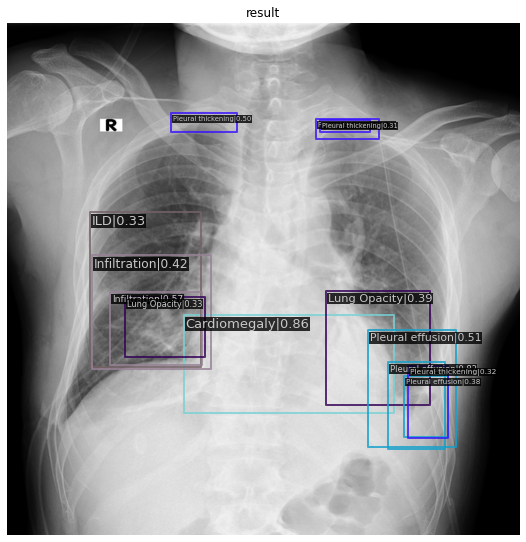

[array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([[1.7629214e+02, 2.9251523e+02, 3.8610049e+02, 3.9058673e+02,
        8.6026019e-01],
       [9.9522614e+01, 2.3602399e+02, 4.0693359e+02, 3.9527820e+02,
        7.0340268e-02]], dtype=float32), array([[1.2607642e+02, 2.7838782e+02, 1.8899234e+02, 3.3204163e+02,
        2.9123613e-01],
       [3.1261343e+02, 2.7721396e+02, 3.8767703e+02, 3.8176880e+02,
        1.7666382e-01],
       [2.9754288e+02, 2.5923999e+02, 4.2448407e+02, 3.7707047e+02,
        6.3791402e-02]], dtype=float32), array([[8.2097809e+01, 1.8971356e+02, 1.9350313e+02, 3.4495764e+02,
        3.2850841e-01],
       [9.5596115e+01, 2.5367250e+02, 1.9228502e+02, 3.4102118e+02,
        8.7230779e-02],
       [1.1900338e+02, 2.1443306e+02, 2.0835077e+02, 3.4143909e+02,
        5.0774194e-02]], dtype=float32), array([[1.0237785e+02, 2.6960342e+02, 1.9463684e+02, 3.4289212e+02,
        5.6675661e-01],


In [31]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)
print(predictions)

In [32]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape

(14, (0, 5), (0, 5), (0, 5), (2, 5))

모든 테스트 데이터에 대해 추론을 진행합니다.

In [36]:
test_df= pd.read_csv('/content/drive/MyDrive/project/vinBigData/test.csv')

In [37]:
test_df

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376
...,...,...,...
2995,7f5503caa936a623b4388fbd88e890c5,2642,3170
2996,c97e54a78bab9c05ce2e04fe6c284bcd,3072,3072
2997,33218cf183c1224a74ccfb514e827e15,2336,2836
2998,04b700c4815f088728db9f093c739707,2484,3064


In [38]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [39]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.4 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
        
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)

    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        
        # 1024절대좌표
        boxes = boxes[indexes]


        # 1024 상대좌표
        boxes_relative=boxes/1024.0
        
        # test 해상도 width, height
        test = test_df[test_df['image_id'] == image_id]
        test_width = float(test['width'])
        test_height = float(test['height'])

        # xmin ymin xmax ymax
        # x * width
        # y * height
        for i,box in enumerate(boxes_relative):
            box[0] = float(box[0] * test_width)
            box[1] = float(box[1] * test_height) 
            box[2] = float(box[2] * test_width)
            box[3] = float(box[3] * test_height)

        # 최종 좌표
        boxes = boxes_relative
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [40]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(3000, 2)

In [41]:
submission.to_csv(f'/content/drive/MyDrive/project/vinBigData/submission/faster/mmdedtection_colab_faster_{EPOCHS}_2_1.csv', index=False)